# Applying a filter to the nuclei image

In [1]:
from __future__ import division

The goal of the image pre-processing is often to optimize the image with respect to the segmentation. Possible operationsare.
  
  + smoothing (enhance S/N)
  + noise reduction
  + contrast sharpening 
  + edge detection   

The specific preprocessing steps used in a pipeline depend on the type of image, the microscopy technique used, the image quality, and the desired downstream analysis.
In this pipeline we will be using a **median filter**.

Median filtering is useful as a **smoothing technique** to reduce noice. The median filter considers each pixel in the image in turn and looks at its nearby neighbors to decide whether or not it is representative of its surroundings. Instead of simply replacing the pixel value with the mean of neighboring pixel values, it replaces it with the median of those values. The median is calculated by sorting all the pixel values from the **surrounding neighborhood** into numerical order and returning the pixel value in the middle.

## Exercises  1 -  Connect  to the omero server

In [2]:
# The 2 lines below are there to set the path to the OMERO python client. 
import sys
sys.path.append('../../OMERO.server/lib/python')
from omero.gateway import BlitzGateway
from getpass import getpass

host = "localhost"
port = 4064
username = 'user1'

# Use the getpass function to ask the user for the password (mifobio2018) and asign it to a variable (=)
passwd = getpass("Passwd: ")

# Create a new BlitzGateway by calling the BlitzGateway funcion with the parameters: Username, Password, Host and Port
conn = BlitzGateway(username, passwd, host=host, port=port)

# Use connect function to connect you to the omero server.
conn.connect()

Passwd: ········


True

## Exercises  2 -  Getting Images


Images in Dataset: Well-C003
FITC.jpeg 
Hoechst.jpeg 
Tritc.jpeg 
{'FITC': [array([[19, 19, 19, ..., 22, 22, 22],
       [19, 19, 19, ..., 22, 22, 22],
       [19, 19, 19, ..., 22, 22, 22],
       ...,
       [18, 18, 18, ..., 20, 20, 20],
       [18, 18, 18, ..., 20, 20, 20],
       [18, 18, 18, ..., 20, 20, 20]], dtype=uint8)], 'Tritc': [array([[16, 16, 16, ..., 18, 18, 18],
       [16, 16, 16, ..., 18, 18, 18],
       [16, 16, 16, ..., 18, 18, 18],
       ...,
       [15, 15, 15, ..., 16, 16, 16],
       [15, 15, 15, ..., 16, 16, 16],
       [15, 15, 15, ..., 16, 16, 16]], dtype=uint8)], 'Hoechst': [array([[14, 14, 14, ..., 16, 16, 16],
       [14, 14, 14, ..., 16, 16, 16],
       [14, 14, 14, ..., 16, 16, 16],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], dtype=uint8)]}


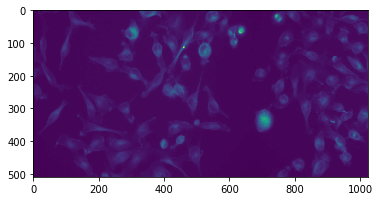

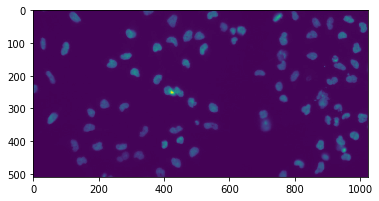

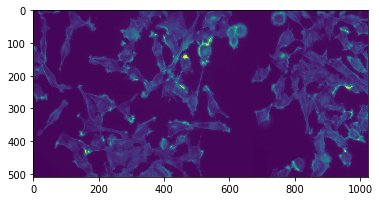

In [8]:
# Create a dictionary that contains a key-value pairing for each image.
# The keys should be a strings describing the name of the image 
# and the values should be empty lists. These empty lists will be filled with the array of image created.

img = {"FITC":[],
       "Hoechst":[],
       "Tritc":[]}


# Create a function to return images from the dataset PK-11B and the Well-C003.
# Fill in the ..
# This function takes two parameters, a dataset_id and the connection variable
# To get an image array you can use getPrimaryPixels() to get all pixels from an image.
# To add new elements to a list you should use the method append.

import matplotlib.pyplot as plt

def getImagesFrom(dataset_id, conn):
    dataset = conn.getObject("Dataset", dataset_id)
    print "\nImages in Dataset:", dataset.getName()
    for image in dataset.listChildren():
        print image.getName(), image.getDescription()
        pixels = image.getPrimaryPixels()
        image_plane = pixels.getPlane(0, 0, 0)
        if image.getName() == "FITC.jpeg":
            img["FITC"].append(image_plane)
        if image.getName() == "Hoechst.jpeg":
            img["Hoechst"].append(image_plane)
        if image.getName() == "Tritc.jpeg":
            img["Tritc"].append(image_plane)
    return(img)
        
im = getImagesFrom(7, conn)

# print the content of the variable 'im'
print im

# Visualize the list of images obtained using plt.imshow then plt.show
plt.imshow(im['FITC'][0])
plt.show()
plt.imshow(im['Hoechst'][0])
plt.show()
plt.imshow(im['Tritc'][0])
plt.show()

## Exercises 3 - Normalize images

In [9]:
# Normalize images
# In order to compare two images we can use the numpy.iinfo function. This function will show us the range of a 
# data-type, which we can then use to normalize the intensity values in the image.
import numpy

max1 = numpy.iinfo(im['FITC'][0].dtype).max
im['FITC'][0] = im['FITC'][0] / max1
max2 = numpy.iinfo(im['Hoechst'][0].dtype).max
im['Hoechst'][0] = im['Hoechst'][0] / max2
max3 = numpy.iinfo(im['Tritc'][0].dtype).max
img["Tritc"][0] = img["Tritc"][0] / max3

# Print the first plane of one of the images to check that the values are between 0 and 1.
# Note that when you run the cell multiple times without having run the previous cell before,
# the values will become smaller and smaller.

print im['FITC'][0]

# NOTE that you will get an error if you run the cell multiple times without having run the previous
# cell each time before, since the type of the data will change from an int type to a float type that
# does not have a maximum value. 

[[0.0745098  0.0745098  0.0745098  ... 0.08627451 0.08627451 0.08627451]
 [0.0745098  0.0745098  0.0745098  ... 0.08627451 0.08627451 0.08627451]
 [0.0745098  0.0745098  0.0745098  ... 0.08627451 0.08627451 0.08627451]
 ...
 [0.07058824 0.07058824 0.07058824 ... 0.07843137 0.07843137 0.07843137]
 [0.07058824 0.07058824 0.07058824 ... 0.07843137 0.07843137 0.07843137]
 [0.07058824 0.07058824 0.07058824 ... 0.07843137 0.07843137 0.07843137]]


## Exercises 4 - Apply median filter on images

In [17]:
# Create a variable for the size of the smoothing filter and set it to an appropriate value. 
# Either the sizes of a rectangular kernel or the footprint of the kernel must be provided. 
# The size parameter, if provided, must be a sequence of sizes or a single number in which case the size of 
# the filter is assumed to be equal along all axis. 
# The footprint if provided, must be an array that defines the shape of the kernel by its non-zero elements.
filter_size = 3

In [18]:
# Perform the smoothing on the image
# To do so, use the median filter function 'scipy.ndimage.filters.median_filter' from the 
# image processing package ndimage. The first parameter is the image and the second the filter-size. 
# Check the documentation for more options of the filter..
import scipy.ndimage
smoothed_image = scipy.ndimage.filters.median_filter(im['Hoechst'][0], filter_size)

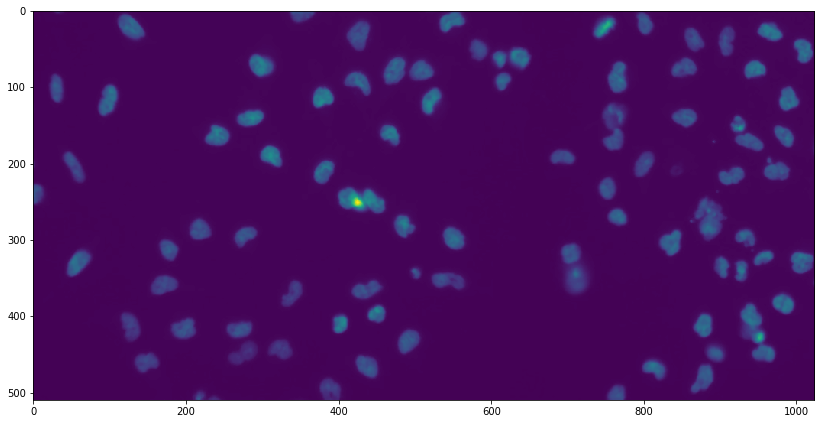

In [19]:
# Visualize the result using plt.imshow and plt.show
plt.figure(figsize=[14, 14])
plt.imshow(smoothed_image)
plt.show()

# Global Thresholding

Otsu's method is used to perform **clustering based image thresholding**. Assuming a **bi-modal intensity distribution**, pixels are separate into foreground and background. The optimal threshold value to separate the two classes is determined by **minimizing the combined intra-class variance or by maximizing the combined inter-class variance**.

## Exercises 5 - Otsu's thresholding method

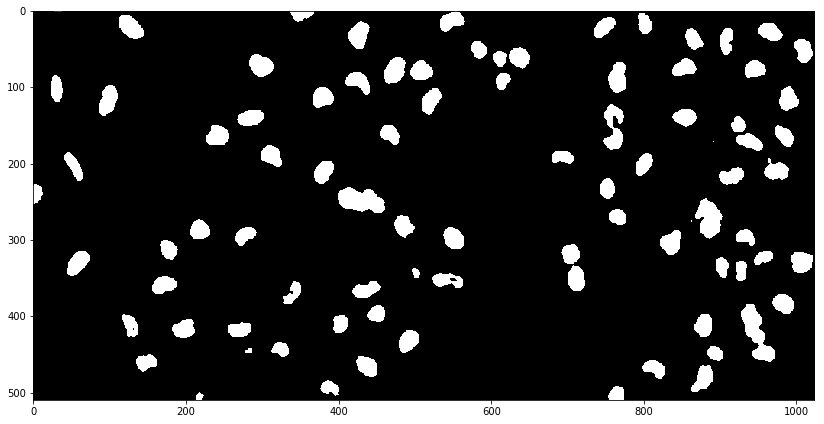

In [20]:
# Threshold the median-smoothed original image using the otsu method to obtain the nuclei mask. You find 
# an implementation of the Otsu-threshold in the module skimage.filters under the name threshold_otsu.
# In the original image, set pixels with values higher than the threshold to 1 and pixels with values lower or equal to 
# the threshold to 0. You can use a "relational operator" to do this, since numpy arrays will automatically perform 
# element-wise comparisons when compared to other arrays of the same shape. 

# First create a an array of the same size as the smoothed image containing zeros everywhere, then use the relational operator to set values above the threshold 
# to one. For example for two arrays a and b of the same shape, running a[b>8]=1 , will set all values in 'a' to one where
# the values in b are bigger then 8.
from skimage.filters import threshold_otsu

nmask = numpy.zeros(smoothed_image.shape, dtype = bool)
thresholdValue = threshold_otsu(smoothed_image)
nmask[smoothed_image > thresholdValue] = 1

# Visualize the result using plt.imshow and plt.show
plt.figure(figsize=(14,14))
plt.imshow(nmask, cmap = 'gray')
plt.show()

# Improving Masks with Binary Morphology

Morphological operations such as **erosion, dilation, closing and opening** are common tools used (among other things) to improve masks after they are generated by thresholding.
They can be used to fill small holes, remove noise, increase or decrease the size of an object, or smoothen mask outlines.
Most morphological operations are - once again - simple kernel functions that are applied at each pixel of the image based on their neighborhood as defined by a structuring element (SE). For example, dilation simply assigns to the central pixel the maximum pixel value within the neighborhood; it is a maximum filter. Conversely, erosion is a minimum filter. Additional options emerge from combining the two: morphological closing, for example, is a dilation followed by an erosion. This is used to fill in gaps and holes or smoothing mask outlines without significantly changing the mask's area.
Finally, there are also some more complicated morphological operations, such as **hole filling**.

## Exercises 6 - Morphological operations

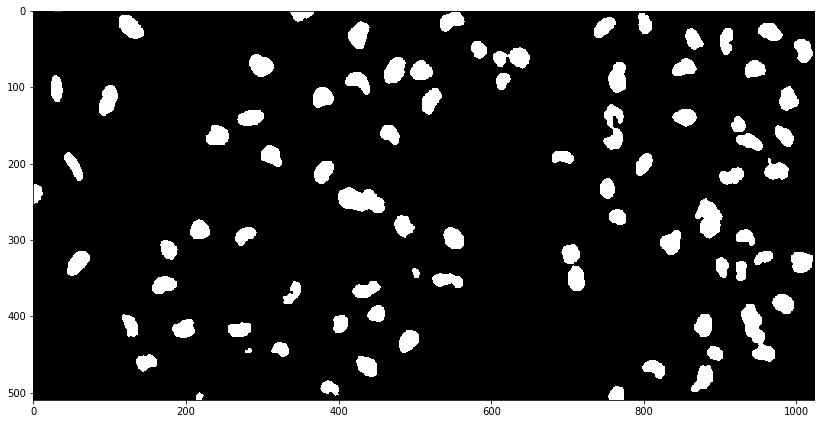

In [29]:
# Create a diamond-shaped structuring element and asign it to a new variable.
# Structuring elements are small binary images that indicate which pixels 
# should be considered as the 'neighborhood' of the central pixel.
# You can use skimage.morphology.diamond to create diamond-shaped structuring element

from skimage.morphology import diamond
se = diamond(1)

# Try morphological operations to further improve the mask
# The various operations are available in skimage and ndimage, 
# for example skimage.morphology.closing and scipy.ndimage.morphology.binary_fill_holes
from skimage.morphology import closing
from skimage.morphology import opening
from scipy.ndimage import binary_fill_holes 


nmask = opening(closing(nmask, se),se)
nmask = binary_fill_holes(nmask)

# Visualize the result using plt.imshow and plt.show
plt.figure(figsize=(14,14))
plt.imshow(nmask, cmap = 'gray')
plt.show()

## Exercises 7 - Save image locally

In [35]:
## import imsave from skimage.io
## convert the image nmask to 8-bit with values 0 and 255 and save the nmask.
from skimage.io import imsave
nmask = nmask.astype(numpy.uint8)
nmask = nmask * 255
print(nmask.dtype)
imsave('../exercises/nmask.tif', nmask, plugin='tifffile')

uint8
